# Hough Transform

In this exercise, we will implement a Hough transform in order to detect parametric curves, such as lines or circles.
In the following, we shortly review the motivation for this technique.

Consider the point $p=(\mathtt{x},\mathtt{y})$ and the equation for a line $y = mx+c$. What are the lines that could pass through $p$?
The answer is simple: all the lines for which $m$ and $c$ satisfy $\mathtt{y} = m\mathtt{x}+c$.
Regarding $(\mathtt{x},\mathtt{y})$ as fixed, the last equation is that of a line in $(m,c)$-space.
Repeating this reasoning, a second point $p'=(\mathtt{x}',\mathtt{y}')$ will also have an associated line in parameter space, and the two lines will intersect at the point $(\tilde{m},\tilde{c})$, which corresponds to the line connecting $p$ and $p'$.

In order to find lines in the input image, we can thus pursue the following approach.
We start with an empty accumulator array quantizing the parameter space for $m$ and $c$.
For each edge pixel in the input image, we then draw a line in the accumulator array and increment the corresponding cells.
Edge pixels on the same line in the input image will produce intersecting lines in $(m,c)$-space and will thus reinforce the intersection point.
Maxima in this array thus correspond to lines in the input image that many edge pixels agree on.

In practice, the parametrization in terms of $m$ and $c$ is problematic, since the slope $m$ may become infinite.
Instead, we use the following parametrization in polar coordinates:
\begin{equation}
	\mathtt{x}\cos\theta + \mathtt{y}\sin\theta = \rho \label{eq:hough_line}
\end{equation}
This produces a sinusoidal curve in $(\rho,\theta)$-space, but otherwise the procedure is unchanged.

The following sub-questions will guide you through the steps of building a Hough transform.

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2


Bad key "text.kerning_factor" on line 4 in
/home/pk/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Hough Voting
Build up an accumulator array ``acc`` for the parameter space $(\rho, \theta)$. $\theta$ ranges from $-\pi/2$ to $\pi/2$, and $\rho$ ranges from $-D$ to $D$, where $D$ denotes the length of the image diagonal.
Use ``n_bins_rho`` and ``n_bins_theta`` as the number of bins in each direction.
Initially, the array should be filled with zeros.

For each edge pixel in the input image, create the corresponding curve in $(\rho, \theta)$ space by evaluating above line equation for all values of $\theta$ and incrementing the corresponding cells of the accumulator array.

In [3]:
def hough_transform(edge_image, n_bins_rho, n_bins_theta):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, n_bins_theta), dtype=np.int)  
    
    # Create bins
    diag = np.linalg.norm(edge_image.shape)  # Length of image diagonal
    theta_bins = np.linspace(-np.pi / 2, np.pi / 2, n_bins_theta)
    rho_bins = np.linspace(-diag, diag, n_bins_rho)
    
    # YOUR CODE HERE
    # the unique values of edge_image     
    print(np.unique(edge_image, return_counts=True))
    
    
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            #print(edge_image[y,x],(x,y))
            
            # it is better just compute for edges , so edges' value is 0 or 255 and for egdes the value is 255 
            # and for non edges the value of edge_image[y,x] is 0
            if edge_image[y,x]==0:
                continue
            for index_theta,theta in enumerate(theta_bins):
            
                rho = x*np.cos(theta) + y*np.sin(theta)
                
                #nearest_val = rho_bins[abs(rho_bins-rho)==abs(rho_bins-rho).min()] # If you directly want the element of array (rho_bins) nearest to the given number (rho)
                #index_rho = np.where(abs(rho_bins-rho)==abs(rho_bins-rho).min())[0][0] # If you want the index of the element of array (rho_bins) nearest to the the given number (rho)
                index_rho = int((rho+diag)/(2*diag)*n_bins_rho)
            
                votes[index_rho,index_theta] += 1
                
    
    #raise NotImplementedError()
    return votes, rho_bins, theta_bins

Now we can test the implementation on an example image and visualize the resulting Hough space by displaying it as a 2D image.

In [4]:
color_im = imageio.imread('gantrycrane.png')
print(color_im.shape)
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY)

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

hough_space, rho_bins, theta_bins = hough_transform(edges, n_bins_rho=300, n_bins_theta=300)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(color_im)
axes[0].set_title('Image')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges')
axes[2].imshow(hough_space)
axes[2].set_title('Hough space')
axes[2].set_xlabel('theta (index)')
axes[2].set_ylabel('rho (index)')
fig.tight_layout()

(264, 400, 3)
(array([  0, 255], dtype=uint8), array([98617,  6983]))


<IPython.core.display.Javascript object>

## Non-Maximum Suppression and Finding Peaks
Write a function ``nms2d`` which suppresses all points in the Hough space that are not local maxima.
This can be achieved by looking at the 8 direct neighbors of each pixel and keeping only pixels whose value is greater than all its neighbors.

This function is simpler than the non-maximum suppression from the Canny Edge Detector exercise, since it does not take into account local gradients.

Tip: think about what to do at the borders of the Hough array. What happens if we simply ignore the border areas? How should we treat it to be precise? (Remember that theta represents an angle that wraps around back to itself).

In [5]:
def BORDER_REFLECT_101(a):
    #mirroring_without_duplicate_border
    # m1+m2+m3
    # m4+m5+m6
    # m7+m8+m9
    
    a_filipped_vert = np.flip(a,1)
    a_filipped_hori = np.flip(a,0)
    m5 = np.copy(a)
    m4 = a_filipped_vert
    m4 = m4[:,:-1]

    m6 = a_filipped_vert
    m6 = m6[:,1:]
    
    m2 = a_filipped_hori
    m2 = m2[:-1,:]
    
    m8 = a_filipped_hori
    m8 = m8[1:,:]
    
    m1 = np.copy(m2[:,1:])
    m1 = np.flip(m1,1)
    
    m3 = np.copy(m2[:,:-1])
    m3 = np.flip(m3,1)
    
    m7 = np.copy(m8[:,1:])
    m7 = np.flip(m7,1)
    
    m9 = np.copy(m8[:,:-1])
    m9 = np.flip(m9,1)
    

    m123 = np.concatenate((m1,m2,m3), axis=1)
    m456 = np.concatenate((m4,m5,m6), axis=1)
    m789 = np.concatenate((m7,m8,m9), axis=1)
    final_a = np.concatenate((m123,m456,m789),axis=0)

    
    #return final_a
    return final_a[a.shape[0]-2:a.shape[0]*2,a.shape[1]-2:a.shape[1]*2]


In [6]:
def nms2d(hough_array):
    hough_array_out = np.zeros_like(hough_array)
    
    # YOUR CODE HERE
    # we do  not consider the pixels on the border becasue they do not have 8 neighbors
    # we could compare them to the less neighbors but they are removed
    x_neighbor = [1,-1,-1, 0, 1,-1,0,1]
    y_neighbor = [0, 0,-1,-1,-1, 1,1,1]
    for x in range(1,hough_array.shape[1]-1):
        for y in range(1,hough_array.shape[0]-1):
            if hough_array[y,x]==0:
                continue
            neighbors_value = []
            for x_id,y_id in zip(x_neighbor,y_neighbor):
                neighbors_value.append(hough_array[y+y_id,x+x_id])
            if hough_array[y,x] >= max(neighbors_value):
                hough_array_out[y,x] = hough_array[y,x]
                
                
    return hough_array_out

In [7]:
def BORDER_REFLECT_101(a):
    # the function is used to add mirror the borders so we can easily incease the
    # size of the "hough_space" just by one pixel in each side so we can apply 
    # comparision for all pixels of image with considering even the borders
    
    #mirroring_without_duplicate_border
    # m1+m2+m3
    # m4+m5+m6
    # m7+m8+m9
    
    a_filipped_vert = np.flip(a,1)
    a_filipped_hori = np.flip(a,0)
    m5 = np.copy(a)
    m4 = a_filipped_vert
    m4 = m4[:,:-1]

    m6 = a_filipped_vert
    m6 = m6[:,1:]
    
    m2 = a_filipped_hori
    m2 = m2[:-1,:]
    
    m8 = a_filipped_hori
    m8 = m8[1:,:]
    
    m1 = np.copy(m2[:,1:])
    m1 = np.flip(m1,1)
    
    m3 = np.copy(m2[:,:-1])
    m3 = np.flip(m3,1)
    
    m7 = np.copy(m8[:,1:])
    m7 = np.flip(m7,1)
    
    m9 = np.copy(m8[:,:-1])
    m9 = np.flip(m9,1)
    

    m123 = np.concatenate((m1,m2,m3), axis=1)
    m456 = np.concatenate((m4,m5,m6), axis=1)
    m789 = np.concatenate((m7,m8,m9), axis=1)
    final_a = np.concatenate((m123,m456,m789),axis=0)

    
    #return final_a
    return final_a[a.shape[0]-2:a.shape[0]*2,a.shape[1]-2:a.shape[1]*2]


# SECOND FORM OF FUNCTION "nms2d" WHICH IS MORE ACCURATE
def nms2d(hough_array):
    hough_array_out = np.zeros_like(hough_array)
    hough_array = BORDER_REFLECT_101(hough_array)
    # YOUR CODE HERE
    # we do  not consider the pixels on the border becasue they do not have 8 neighbors
    # we could compare them to the less neighbors but they are removed
    x_neighbor = [1,-1,-1, 0, 1,-1,0,1]
    y_neighbor = [0, 0,-1,-1,-1, 1,1,1]
    for x in range(hough_array_out.shape[1]):
        for y in range(hough_array_out.shape[0]):
            if hough_array[y,x]==0:
                continue
            neighbors_value = []
            for x_id,y_id in zip(x_neighbor,y_neighbor):
                neighbors_value.append(hough_array[y+y_id,x+x_id])
            if hough_array[y,x] >= max(neighbors_value):
                hough_array_out[y,x] = hough_array[y,x]
                
                
    return hough_array_out

Write a function ``find_hough_peaks`` that takes the result of ``hough_transform`` as an argument, finds the extrema in Hough space using ``nms2d`` and returns the index of all points $(\rho_i, \theta_i)$ for which the corresponding Hough value is greater than ``threshold``.

In [8]:
def find_hough_peaks(hough_space, threshold):
    # YOUR CODE HERE
    hough_array_out = nms2d(hough_space)
    result = np.where(hough_array_out >=threshold)
    rho_max_idx = result[0]
    theta_max_idx = result[1]
    return  rho_max_idx, theta_max_idx

What would happen if we swapped the order of the thresholding and the NMS operations?

YOUR ANSWER HERE

Now, let's plot the results of your implementation.

In [9]:
def plot_hough_lines(image, rho, theta):
    # compute start and ending point of the line x*cos(theta)+y*sin(theta)=rho
    x0, x1 = 0, image.shape[1] - 1
    y0 = rho / np.sin(theta)
    y1 = (rho - x1 * np.cos(theta)) / np.sin(theta)

    # Check out this page for more drawing function in OpenCV:
    # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    for yy0, yy1 in zip(y0, y1):
        cv2.line(image, (x0, int(yy0)), (x1, int(yy1)), color=(255, 0, 0), thickness=1)

    return image

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 200)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imageio.imread('gantrycrane.png')
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

gantrycrane.png: found 33 lines in the image.


<IPython.core.display.Javascript object>

Is the result correct? Are there any undetected lines or wrong lines returned? If yes, why are those lines missing and why are there false positives? Can you think of ways to avoid those mistakes?

the answer on the whole is correct but there are some vertical lines thart they cannot
be detected (with the threshold = 200) whereas they were present in the edge image and they can be detected with lower threshold, but by decreasing the threshold more redundant lines appear in the image so one solution to get rid of redundant lines and having all lines detected would be to give more votes for stronger edges using magnitude of gradient. 
* by increasing the threshold we can remove some redundant lines and decrease the number of redundant lines 

In [10]:
# Try another image
im = imageio.imread('circuit.png')
print("image shape",color_im.shape)


blurred = cv2.GaussianBlur(im, None, sigmaX=2)
edge = cv2.Canny(blurred, threshold1=30, threshold2=90)
hough_space, rho_bins, theta_bins = hough_transform(edge, n_bins_rho=300, n_bins_theta=300)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 100)
print(f'circuit.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]
color_image = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)
fig.tight_layout()

image shape (264, 400, 3)
(array([  0, 255], dtype=uint8), array([72267,  3893]))
circuit.png: found 50 lines in the image.


<IPython.core.display.Javascript object>

## [BONUS] Circle Hough Transform for Circles

The Hough transform is a general technique that can not only be applied to lines, but also to other parametric curves, such as circles.
In the following, we will show how the implementation can be extended to finding circles.

A circle can be parameterized by the following equation:
$$	
    (\mathtt{x}-a)^2 + (\mathtt{y}-b)^2 = r^2. \label{eq:hough_circle}
$$

Unfortunately, the computation and memory requirements for the Hough transform increase exponentially with the number of parameters.
While a 3D search space is still just feasible, we can dramatically reduce the amount of computation by integrating the gradient direction in the algorithm.

Without gradient information, all values $a, b$ lying on the cone given by above equation are incremented.
With the gradient information, we only need to increment points on an arc centered at $(a, b)$:
$$
\begin{eqnarray}
	a &=& x + r\cos\phi\\
	b &=& y + r\sin\phi,
\end{eqnarray}
$$
where $\phi$ is the gradient angle returned by the edge operator.

Create a function ``hough_circle`` which implements the Hough transform for circles.
Try your implementation for a practical application of counting coins in an image.
You can use the images ``coins1.png`` and ``coins2.png`` for testing.

In [11]:
def hough_circle(img,edge_image,n_bins_rho):
    # Vote accumulator
    votes = np.zeros((edge.shape[0],edge.shape[1],n_bins_rho), dtype=np.int)  
    
    # Create bins

    a_bins = np.arange(edge.shape[1])
    b_bins = np.arange(edge.shape[0])
    
    diag = max(edge.shape)  # maximum length of radius
    rho_bins = np.linspace(-50, 50, n_bins_rho)
    
    
    ### BEGIN SOLUTION
    # Precompute sine and cosine
    dx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    dy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx)
    # here we just need the direction in edge points so we replace other points with zero
    direction [edge_image == 0] =0
    theta = direction
    # Hough transform
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            
            # it is better just compute for edges , so edges' value is 0 or 255 and for egdes the value is 255 
            # and for non edges the value of edge_image[y,x] is 0
            if edge_image[y,x]==0:
                continue
            
            for index_rho,rho in enumerate(rho_bins):
                
                a = x+rho*np.cos(theta[y,x])
                b = y+rho*np.sin(theta[y,x])

                
                if (0<=a<=edge.shape[1]-1) and (0<=b<=edge.shape[0]-1): 
                
                    index_a = int(a)
                    index_b = int(b)
                    

                    votes[index_b,index_a,index_rho] += 1                
    
    #raise NotImplementedError()
    return votes, a_bins , b_bins , rho_bins

In [12]:
def nms3d(hough_array):

    # YOUR CODE HERE
    # we do  not consider the pixels on the border becasue they do not have 8 neighbors
    # we could compare them to the less neighbors but they are removed
    hough_array_out = np.zeros_like(hough_array)

    # generating the neighboring matrix
    
    for x in range(1,hough_array_out.shape[1]-1):
        for y in range(1,hough_array_out.shape[0]-1):
            for rho in range(1,hough_array_out.shape[2]-1):
                
                if hough_array[y,x,rho]==0:
                    continue
                
                neighbors_value = []
                values= [-1,0,1]
                for x_id in values:
                    for y_id in values:
                        for rho_id in values:

                            if x_id==y_id==rho_id==0:
                                continue
                            neighbors_value.append(hough_array[y+y_id,x+x_id,rho+rho_id])

                if hough_array[y,x,rho] >= max(neighbors_value):
                    hough_array_out[y,x,rho] = hough_array[y,x,rho]
                    
                
    return hough_array_out

In [13]:
def find_hough_peaks3d(hough_space, threshold):
    # YOUR CODE HERE
    hough_array_out = nms3d(hough_space)
    result = np.where(hough_array_out >=threshold)
    y_max_idx = result[0]
    x_max_idx = result[1]
    rho_max_idx = result[2]

    return  y_max_idx,x_max_idx,rho_max_idx

In [14]:
def plot_hough_circles(image,a,b, rho):

    for x,y,radius in zip(a,b, rho):
        cv2.circle(image, (int(x),int(y)) , abs(int(radius)), color=(255, 0, 0), thickness=1)

    return image

In [15]:
im = imageio.imread('coins1.jpg')

blurred = cv2.GaussianBlur(im, None, sigmaX=2)
edges = cv2.Canny(blurred, threshold1=30, threshold2=90)

n_bins_rho = 500
hough_space, a_bins , b_bins , rho_bins = hough_circle(im , edges , n_bins_rho)
b_max_idx,a_max_idx,rho_max_idx = find_hough_peaks3d(hough_space, threshold=30)
print(f'circuit.png: found {len(rho_max_idx)} circles in the image.')
b_center_max ,a_center_max ,rho_max = b_bins[b_max_idx] , a_bins[a_max_idx] , rho_bins[rho_max_idx]


color_image = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
image_with_circles = plot_hough_circles(color_image,a_center_max,b_center_max, rho_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_circles)
fig.tight_layout()


circuit.png: found 9 circles in the image.


<IPython.core.display.Javascript object>

## [BONUS] Line Hough Transform with Gradient Information 
The same trick (as in **Part c**) of using the image gradient can be used for lines.
Modify the code from **Part a** to only vote for one line per edge pixel, instead of all the lines running through this pixel.
Can you think of any disadvantages of this approach?

In [16]:
def hough_transform_gradient(img, edge_image, n_bins_rho, n_bins_theta):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, n_bins_theta), dtype=np.int)  
    
    # Create bins
    diag = np.linalg.norm(edge_image.shape)  # Length of image diagonal
    theta_bins = np.linspace(-np.pi-.1, np.pi+.1, n_bins_theta)
    rho_bins = np.linspace(-diag, diag, n_bins_rho)
    
    # YOUR CODE HERE
    # the unique values of edge_image     
    dx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    dy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    
    # magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx)
    # here we just need the direction in edge points so we replace other points with zero
    direction [edge_image == 0] = 0

    theta = direction
    print(theta.min(),theta.max())
    
    
    dict_vote = dict()
    for index_rho in range(n_bins_rho):
        for index_theta in range(n_bins_theta):
            dict_vote[index_rho,index_theta] = []

    print("dict implemented")       
    
    
    
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            #print(edge_image[y,x],(x,y))
            
            # it is better just compute for edges , so edges' value is 0 or 255 and for egdes the value is 255 
            # and for non edges the value of edge_image[y,x] is 0
            if edge_image[y,x]==0:
                continue
            #for index_theta,theta in enumerate(theta_bins):
            if theta[y,x] > np.pi:
                theta[y,x] = np.pi
            if theta[y,x] < -np.pi:
                theta[y,x] = -np.pi
            rho = x*np.cos(theta[y,x]) + y*np.sin(theta[y,x])
            

            #nearest_val = rho_bins[abs(rho_bins-rho)==abs(rho_bins-rho).min()] # If you directly want the element of array (rho_bins) nearest to the given number (rho)
            #index_rho = np.where(abs(rho_bins-rho)==abs(rho_bins-rho).min())[0][0] # If you want the index of the element of array (rho_bins) nearest to the the given number (rho)
            index_rho = int((rho+diag)/(2*diag)*n_bins_rho)
            index_theta = int((theta[y,x]+np.pi+0.1)/(2*np.pi+.2)*n_bins_theta)

            #print(index_theta)
            votes[index_rho,index_theta] += 1
            dict_vote[index_rho,index_theta].append([x,y])   
    
    #raise NotImplementedError()
    return dict_vote,votes, rho_bins, theta_bins

-3.1413083203589 3.141592653589793
dict implemented
gantrycrane.png: found 54 lines in the image.


<IPython.core.display.Javascript object>


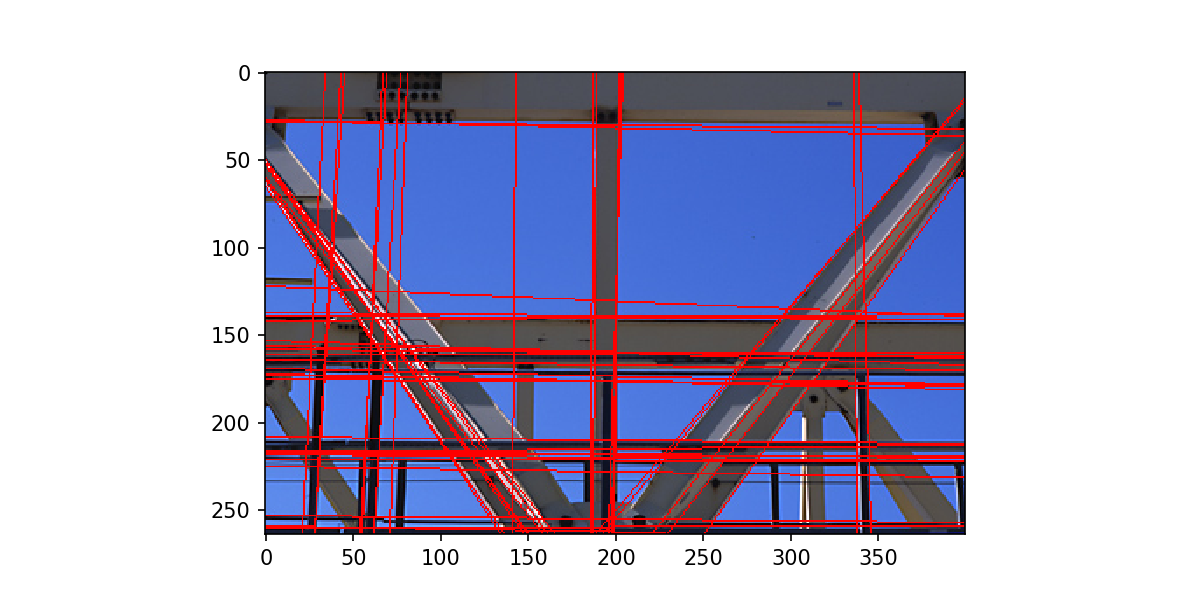

In [21]:
def plot_hough_lines(image, rho, theta):
    # compute start and ending point of the line x*cos(theta)+y*sin(theta)=rho
    x0, x1 = 0, image.shape[1] - 1
    y0 = rho / np.sin(theta)
    y1 = (rho - x1 * np.cos(theta)) / np.sin(theta)

    # Check out this page for more drawing function in OpenCV:
    # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    for yy0, yy1 in zip(y0, y1):
        cv2.line(image, (x0, int(yy0)), (x1, int(yy1)), color=(255, 0, 0), thickness=1)

    return image


color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY)

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

dict_vote,hough_space, rho_bins, theta_bins = hough_transform_gradient(gray_im,edges, n_bins_rho=1000, n_bins_theta=1000)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 6)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imageio.imread('gantrycrane.png')
image_with_lines = plot_hough_lines(color_image,rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

-3.1412596532691017 3.141592653589793
dict implemented
gantrycrane.png: found 54 lines in the image.


<IPython.core.display.Javascript object>


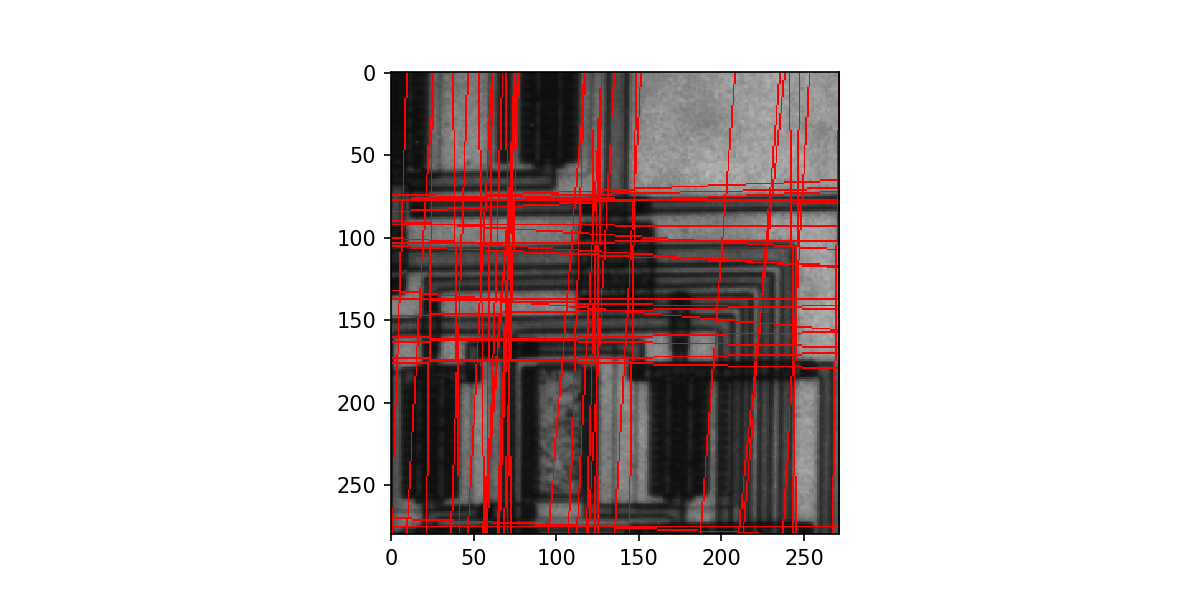

In [22]:
gray_im = imageio.imread('circuit.png')

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

dict_vote, hough_space, rho_bins, theta_bins = hough_transform_gradient(gray_im,edges, n_bins_rho=300, n_bins_theta=300)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 6)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]


color_image = imageio.imread('circuit.png')
color_image = cv2.cvtColor(color_image, cv2.COLOR_GRAY2RGB)

image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

In [ ]:
""" this the funtion of drawing Line segment which has the size of points correspond to the voting 
"""
def finding_points_of_hough_transform(image,dict_vote ,rho_max_idx, theta_max_idx):
    for rho_id,the_id in zip(rho_max_idx, theta_max_idx):
        lists = dict_vote[rho_id,the_id]
        if len(dict_vote[rho_id,the_id]) <2: #select the set of points where there are at least two points for drawing
            continue 

        cv2.line(image, (lists[0][0], lists[0][1]), (lists[-1][0], lists[-1][1]), color=(255, 0, 0), thickness=1)

    return image

-3.1413083203589 3.141592653589793
dict implemented
gantrycrane.png: found 4000000 lines in the image.


<IPython.core.display.Javascript object>


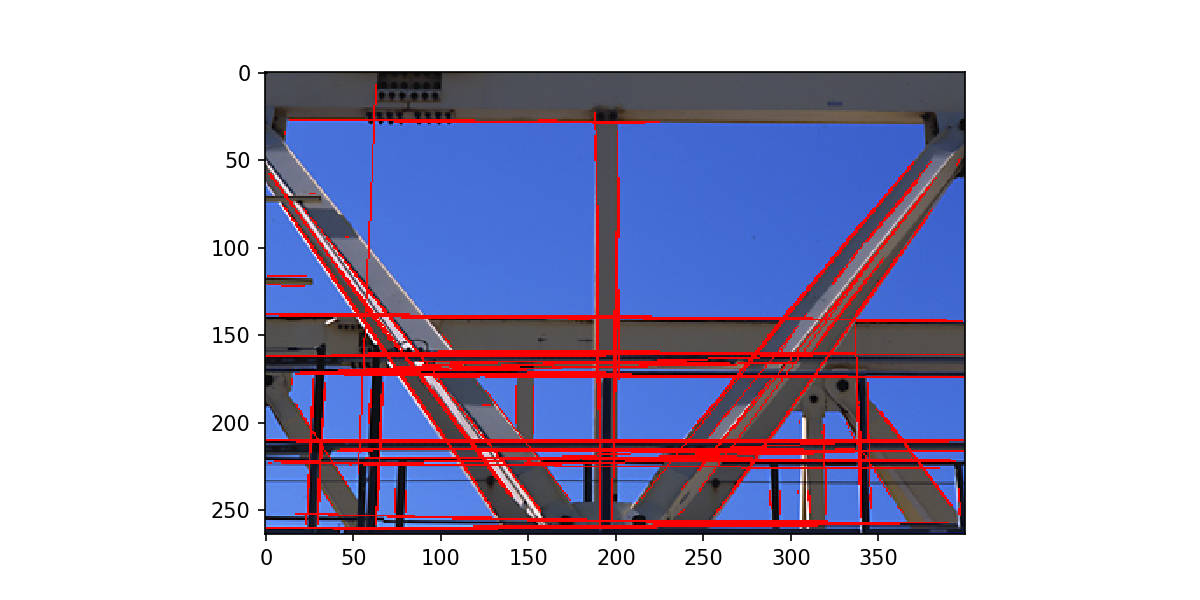

In [23]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY)

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

dict_vote,hough_space, rho_bins, theta_bins = hough_transform_gradient(gray_im,edges, n_bins_rho=2000, n_bins_theta=2000)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 0)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imageio.imread('gantrycrane.png')
image_with_lines = finding_points_of_hough_transform(color_image,dict_vote ,rho_max_idx, theta_max_idx)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

-3.1412596532691017 3.141592653589793
dict implemented
gantrycrane.png: found 1000000 lines in the image.


<IPython.core.display.Javascript object>


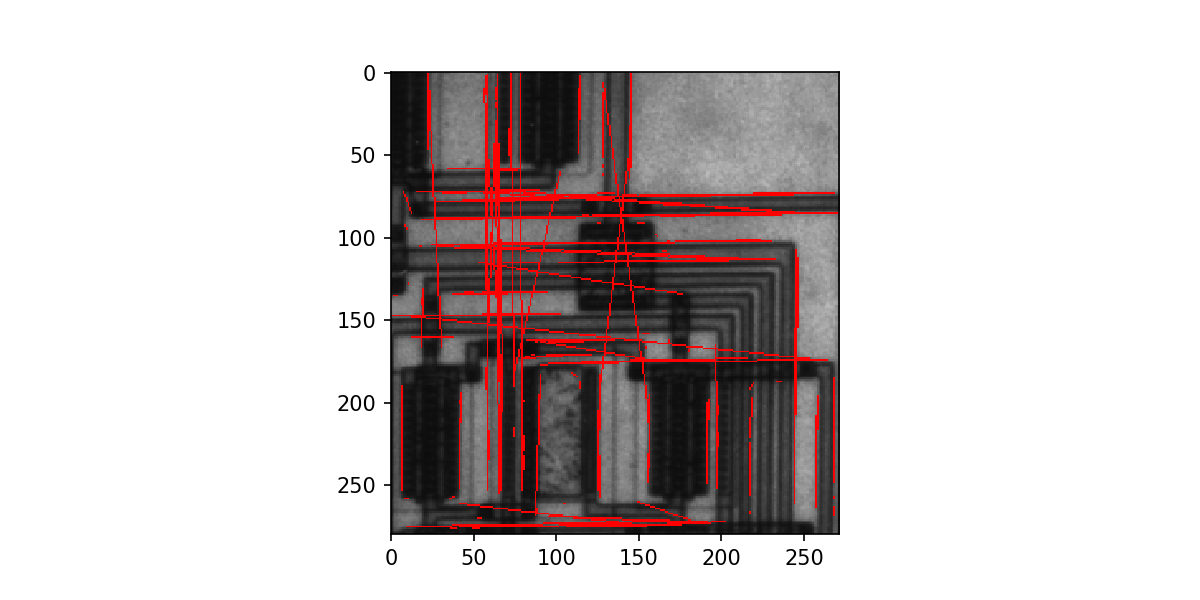

In [37]:
gray_im = imageio.imread('circuit.png')

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

dict_vote, hough_space, rho_bins, theta_bins = hough_transform_gradient(gray_im,edges, n_bins_rho=1000, n_bins_theta=1000)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 0)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]


color_image = imageio.imread('circuit.png')
color_image = cv2.cvtColor(color_image, cv2.COLOR_GRAY2RGB)

image_with_lines = finding_points_of_hough_transform(color_image,dict_vote ,rho_max_idx, theta_max_idx)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

## [BONUS] Counting Coins

Can you build a demo application that takes a photo of several different Euro coins lying on a table as input and tells you how much money it is in total in Euros (i.e. the output is one number)?

How well does it work when the coins start to overlap or lie on top of each other?

Use the functions you wrote in the previous questions.
(Hint: you may need to include a reference shape in the picture in order to obtain the absolute scale, i. e. to convert from pixels to millimeters).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()